In [640]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [641]:
ogTrainData = pd.read_csv('train.csv')
ogTestData = pd.read_csv('test.csv')

trainData = ogTrainData.copy()

In [ ]:
def edit_data(df):
    df.rename(columns={
    "source_1_temperature" : "heater-1",
    "source_2_temperature" : "hvac-1",
    "source_3_temperature" : "hvac-2",
    "source_4_temperature" : "heater-2",
    }, inplace=True)
    
    df["measurement_time"] = pd.to_datetime(df.measurement_time)
    df.insert(1, "time", df.measurement_time.dt.hour)
    df["day_of_week"] = df.measurement_time.dt.dayofweek
    df["is_weekend"] = df.day_of_week >= 5
    df["month"] = df.measurement_time.dt.month
    
    df["total_consumption"] = df[["heater-1", "heater-2", "hvac-1", "hvac-2"]].sum(axis=1)
    df["total_hvac_consumption"] = df[["hvac-1", "hvac-2"]].sum(axis=1)
    df["total_heater_consumption"] = df[["heater-1", "heater-2"]].sum(axis=1)
    
    df["temp_diff"] = df["outside_temperature"] - df["mean_room_temperature"]
    
    df["total_hvac_consump"] = df[["hvac-1", "hvac-2"]].sum(axis=1)
    
    radiation_cols = ["sun_radiation_east", "sun_radiation_west", "sun_radiation_south", "sun_radiation_north"]
    df["dominant_radiation"] = df[radiation_cols].max(axis=1)
    df["total_solar_radiation"] = df[radiation_cols].sum(axis=1)
    df["adjusted_radiation"] = df["total_solar_radiation"] * (1 - df["clouds"])
    
    df["wind_direction_radians"] = np.radians(df["wind_direction"])
    df["wind_y"] = df["wind_speed"] * np.sin(df["wind_direction_radians"])
    df["wind_x"] = df["wind_speed"] * np.cos(df["wind_direction_radians"])
    
    df["hvac_temp_interaction"] = df["total_hvac_consumption"] * df["mean_room_temperature"]
    df["heater_temp_interaction"] = df["total_heater_consumption"] * df["mean_room_temperature"]
    df["wind_temp_interaction"] = df["wind_speed"] * df["mean_room_temperature"]
    df["solar_temp_interaction"] = df["total_solar_radiation"] * df["mean_room_temperature"]
    
    
    
    
    return df



allFeatures = [
'time',
'heater-1',
'hvac-1',
'hvac-2',
'heater-2',
'mean_room_temperature',
'sun_radiation_east',
'sun_radiation_west',
'sun_radiation_south',
'sun_radiation_north',
'sun_radiation_perpendicular',
'outside_temperature',
'wind_speed',
'wind_direction',
'day_of_week',
'is_weekend',
'month',
'total_consumption',
'temp_diff',
'total_hvac_consump',
'dominant_radiation',
'total_solar_radiation',
'adjusted_radiation',
'wind_direction_radians',
'wind_y',
'wind_x',
]

test_features = [
    'solar_temp_interaction', 'wind_temp_interaction'
]

base_features = [
    'heater-1', 'hvac-1', 'heater-2', 'hvac-2',
    'sun_radiation_south', 'sun_radiation_north',
    'mean_room_temperature', 'sun_radiation_east', 'sun_radiation_west',
    'sun_radiation_perpendicular', 'outside_temperature', 'wind_speed',
    'wind_direction', 'clouds'
    ]


# Time Features
time_features = [
    'time', 'day_of_week', 'is_weekend', 'month'
]

# HVAC and Heater Features
hvac_heater_features = [
    'heater-1', 'hvac-1', 'hvac-2', 'heater-2', 'total_hvac_consump', "hvac_temp_interaction", "heater_temp_interaction"
]

# Temperature Features
temperature_features = [
    'mean_room_temperature', 'outside_temperature', 'temp_diff'
]

# Solar Radiation Features
solar_radiation_features = [
    'sun_radiation_east', 'sun_radiation_west', 'sun_radiation_south',
    'sun_radiation_north', 'sun_radiation_perpendicular',
    'total_solar_radiation', 'dominant_radiation', 'adjusted_radiation'
]

# Wind Features
wind_features = [
    'wind_x', 'wind_y'
]

# Consumption Features
consumption_features = [
    'total_consumption'
]



feature_sets = {
    "time_features": time_features,
    "hvac_heater_features": hvac_heater_features,
    "temperature_features": temperature_features,
    "solar_radiation_features": solar_radiation_features,
    "wind_features": wind_features,
    "consumption_features": consumption_features
}

features = list(set(test_features + base_features + time_features + hvac_heater_features + temperature_features + solar_radiation_features + wind_features + consumption_features))

trainData = edit_data(trainData)

#show all columns

#remove all radtiation features
features.remove('sun_radiation_south')
features.remove('sun_radiation_north')
features.remove('sun_radiation_east')
features.remove('sun_radiation_west')
features.remove('sun_radiation_perpendicular')
features.remove('clouds')
features.remove('wind_direction')
features.remove('day_of_week')
features.remove('month')
features.remove('total_hvac_consump')
features.remove('adjusted_radiation')


pd.set_option('display.max_columns', None)

In [643]:
trainingDataX = trainData[features]
trainingDataY = trainData["target"]

print("X train shape:", trainingDataX.shape)
print("Y train shape:", trainingDataY.shape)

X train shape: (7047, 20)
Y train shape: (7047,)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

In [645]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

def time_transformer(df):
    df["hour_sin"] = np.sin(df["time"] / 24 * 2 * np.pi)
    df["hour_cos"] = np.cos(df["time"] / 24 * 2 * np.pi)
    return df


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    trainingDataX, trainingDataY, test_size=0.3, random_state=42, shuffle=False
)

base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, max_depth=20, n_jobs=-1)),
    ('gb', GradientBoostingRegressor(n_estimators=100, max_depth=20, n_jobs=-1))
]

meta_model = LinearRegression()

stack = StackingRegressor(estimators=base_models, final_estimator=meta_model, n_jobs=-1)

steps = [
    ('time_transformer', FunctionTransformer(time_transformer)),
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler()),
    ('stacking', stack)
]

pipe = Pipeline(steps)

def GridSearch():
    #{'imputer__n_neighbors': 5, 'model__max_depth': 20, 'model__n_estimators': 100}
    param_grid = {
        'imputer__n_neighbors': [5, 10, 50],
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [10, 20, 30],
    }



    grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error', verbose=3)

    grid.fit(X_train, y_train)

    #use negative mae
    print("Best parameters: ", grid.best_params_)
    print("Best score: ", grid.best_score_)

MAEs = np.array([])
pipe.fit(X_train, y_train)

scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
print("Mean MAE:", -scores.mean())
pipe

Mean MAE: 3.8662399571338453


Pipeline(steps=[('time_transformer',
                 FunctionTransformer(func=<function time_transformer at 0x000001A360FE8B80>)),
                ('imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('model', RandomForestRegressor(max_depth=20, n_jobs=-1))])

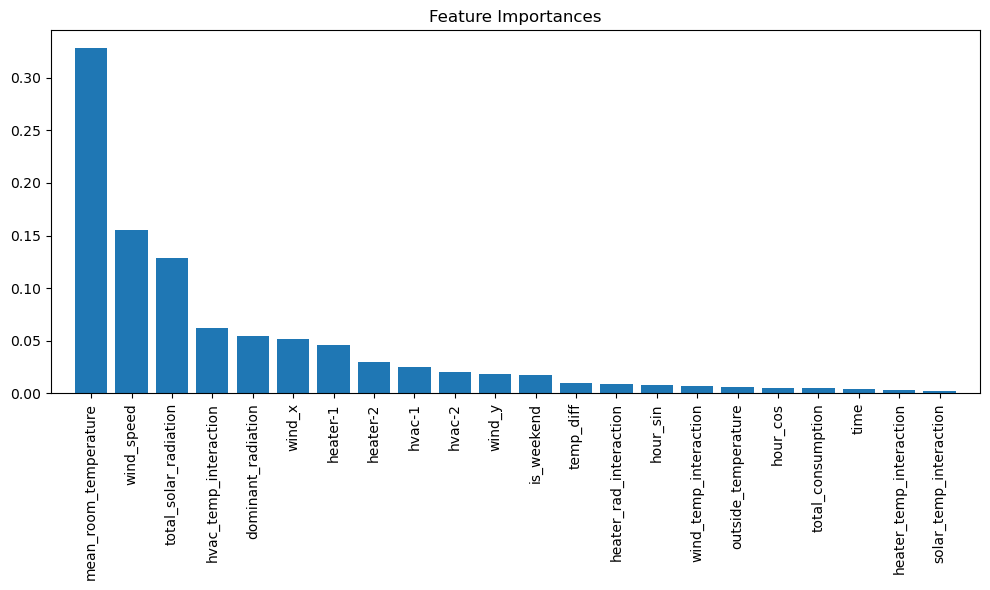

In [647]:
model = pipe.named_steps['model']  # Replace 'model' with the name of your pipeline's model step

# Extract feature importances
importances = model.feature_importances_

# Ensure feature names match the trained features
trained_features = X_train.columns  # Replace with the exact features used for training

# Sort feature importances
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), trained_features[indices - 2], rotation=90)
plt.xlim([-1, len(importances)])
plt.tight_layout()
plt.show()

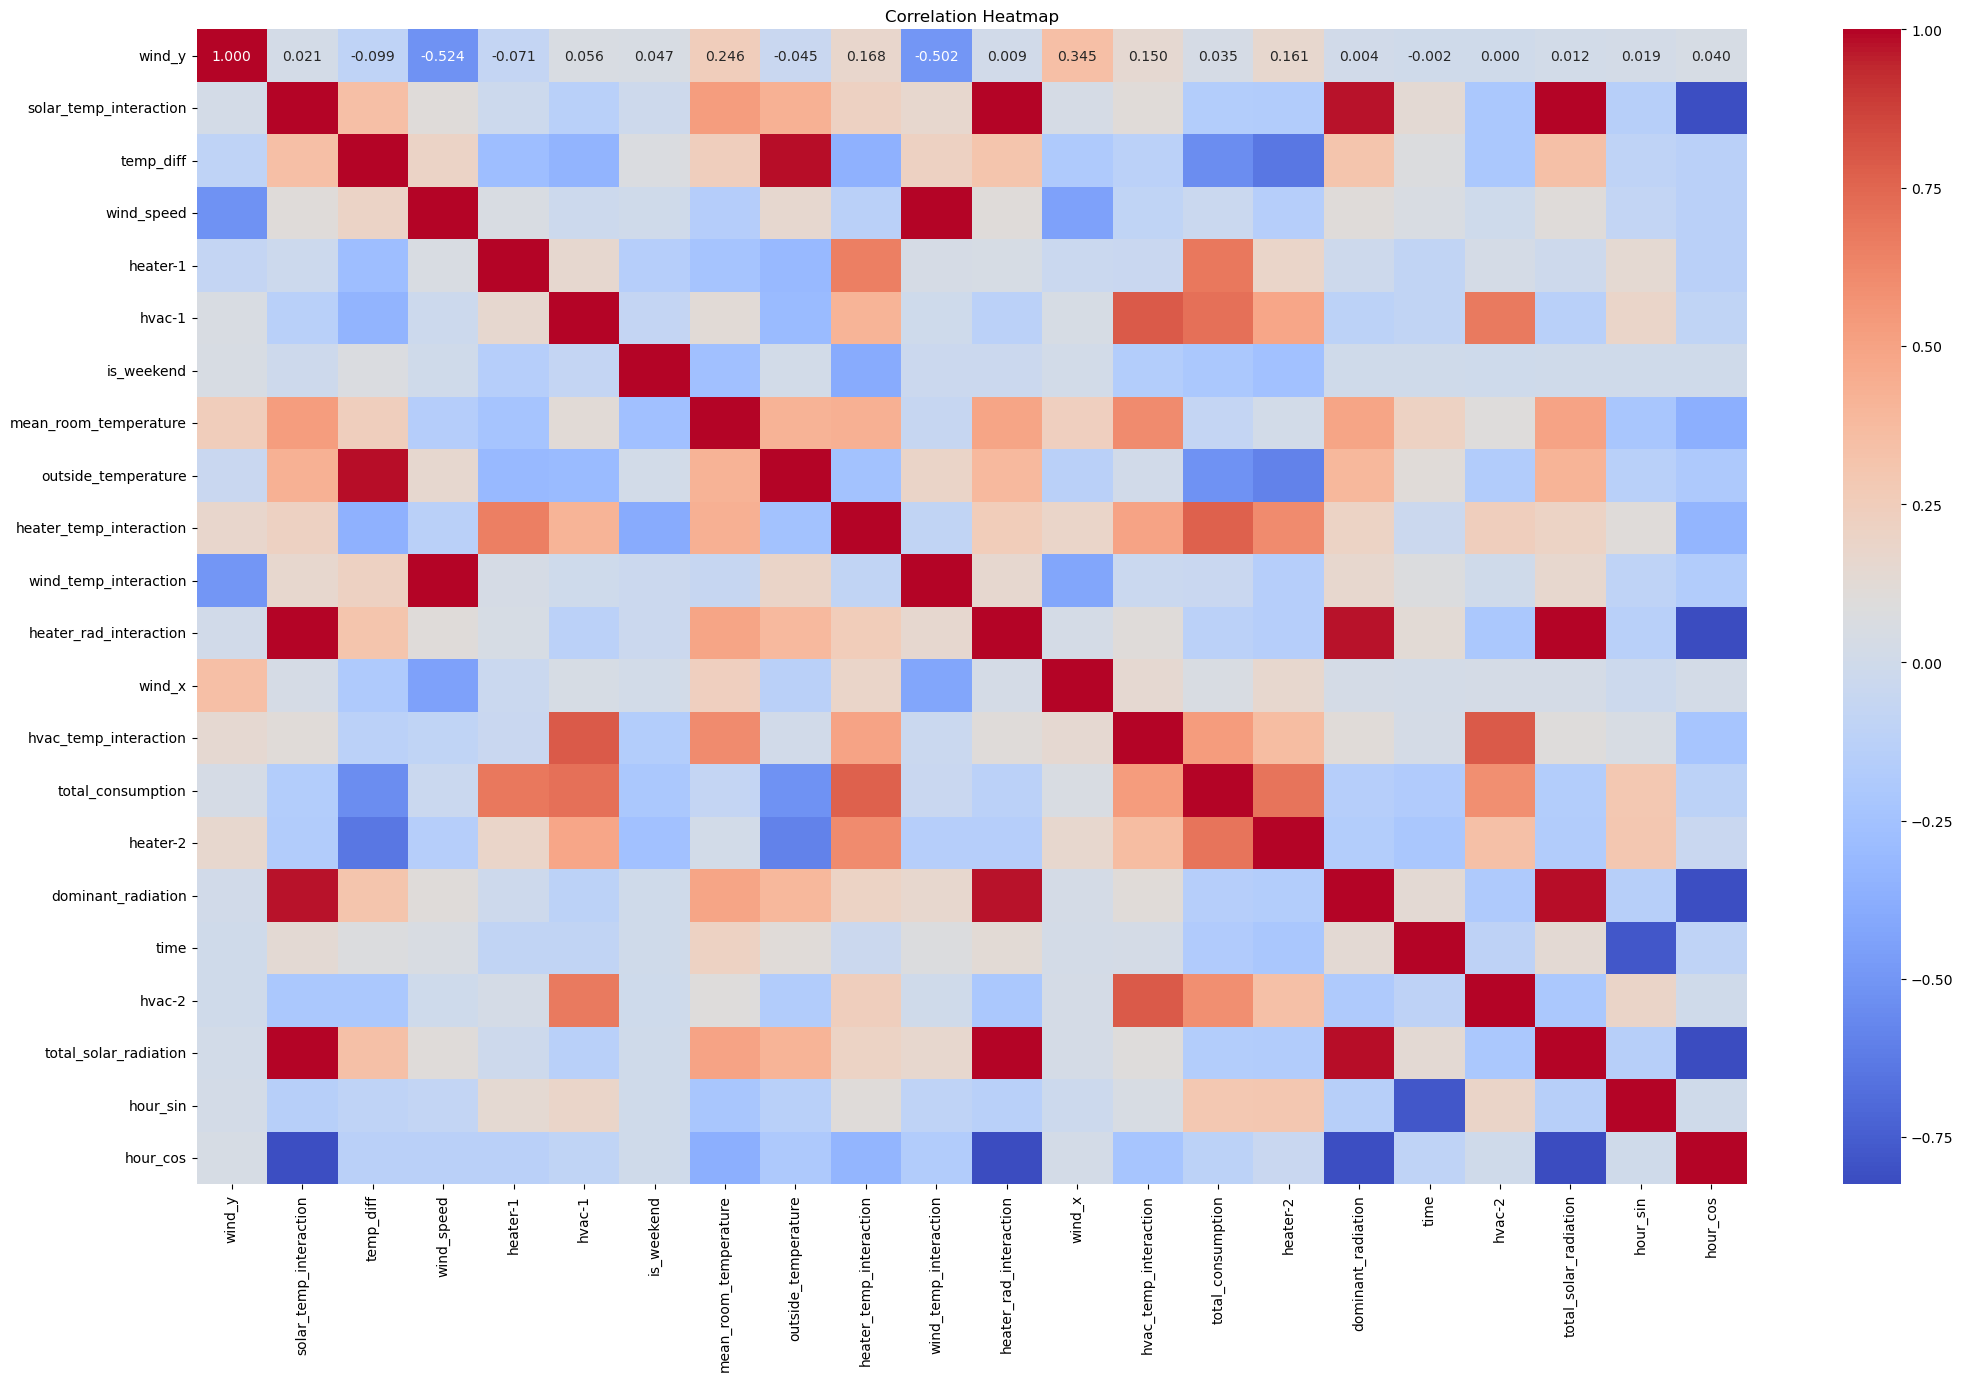

In [648]:
# Compute the correlation matrix
correlation_matrix = X_train.corr()
# Plot a heatmap
plt.figure(figsize=(25, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".3f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [649]:
# imputer = KNNImputer(n_neighbors=5)

# original_columns = X_train.columns  
# original_index = X_train.index      

# imputer = KNNImputer(n_neighbors=5)
# X_train_imputed = imputer.fit_transform(X_train)
# X_test_imputed = imputer.transform(X_test)

# X_train = pd.DataFrame(X_train_imputed, columns=original_columns, index=original_index)
# X_test = pd.DataFrame(X_test_imputed, columns=original_columns, index=X_test.index)

In [650]:
# model = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)

# model.fit(X_train, y_train)

# from sklearn.metrics import mean_absolute_error

# y_pred = model.predict(X_test)


# print("Mean MAE: ", mean_absolute_error(y_test, y_pred))

In [651]:
import itertools
def select_features(X, feature_names):
    """Selects only the specified feature names from the dataset."""
    return X[feature_names]

def testing_with_pipeline(feature_sets, X_train, X_test, y_train, y_test):
    results = []
    for r in range(1, len(feature_sets) + 1):  # Test combinations of 1 group, 2 groups, ..., all groups
        for combination in itertools.combinations(feature_sets.keys(), r):
            # Combine selected feature groups into a single feature list
            selected_features = [feature for group in combination for feature in feature_sets[group]]
            
            # Train the pipeline
            pipe.fit(X_train, y_train)
            
            # Evaluate performance
            y_pred = pipe.predict(X_test)
            mae = mean_absolute_error(y_test, y_pred)
            
            # Store results
            results.append({"combination": combination, "mae": mae})
            print(f"Tested combination: {combination}, MAE: {mae}")

          
    best_result = min(results, key=lambda x: x["mae"])
    print(" ")
    print(" ")
    print("Best Feature Combination: ", best_result["combination"])
    print("MAE: ", best_result["mae"])
    return results

testing_with_pipeline(feature_sets, X_train, X_test, y_train, y_test)

print("")

Tested combination: ('time_features',), MAE: 4.280946621072578
Tested combination: ('hvac_heater_features',), MAE: 4.225434564964796
Tested combination: ('temperature_features',), MAE: 4.288395872788708
Tested combination: ('solar_radiation_features',), MAE: 4.359337606025841
Tested combination: ('wind_features',), MAE: 4.296593327194649
Tested combination: ('consumption_features',), MAE: 4.2660047010147535
Tested combination: ('time_features', 'hvac_heater_features'), MAE: 4.286014538076809
Tested combination: ('time_features', 'temperature_features'), MAE: 4.3114029243294265
Tested combination: ('time_features', 'solar_radiation_features'), MAE: 4.280289458032931
Tested combination: ('time_features', 'wind_features'), MAE: 4.268651686445581
Tested combination: ('time_features', 'consumption_features'), MAE: 4.300355554470254
Tested combination: ('hvac_heater_features', 'temperature_features'), MAE: 4.3096988143555555
Tested combination: ('hvac_heater_features', 'solar_radiation_featu

KeyboardInterrupt: 

In [652]:
finalData = edit_data(ogTestData.copy())
finalPipe = Pipeline(steps)

finalPipe.fit(trainingDataX[features], trainingDataY)
finalPred = finalPipe.predict(finalData[features])

finalPred = pd.DataFrame(finalPred, columns=["target"])
finalPred.index = ogTestData['ID']
finalPred.count = None
finalPred.to_csv("submission.csv")

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_26608\176391563.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hour_sin"] = np.sin(df["time"] / 24 * 2 * np.pi)
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_26608\176391563.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hour_cos"] = np.cos(df["time"] / 24 * 2 * np.pi)
